# Load Data

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [2]:
# reflect database table into classes
engine = create_engine("sqlite:///db/kickstarter_campaigns.sqlite", echo=False)

Base = automap_base()
Base.prepare(engine, reflect=True)
Kickstarter = Base.classes.kickstarter_campaigns

session = Session(engine)

In [3]:
data = engine.execute('SELECT * FROM kickstarter_campaigns')
kickstarter_df = pd.DataFrame()
record_list = []
for record in data:
    record_list.append(record)
    
kickstarter_df = pd.DataFrame(record_list)
kickstarter_df.columns = ['index','backers_count','blurb','country','currency','deadline','fx_rate','goal','id',
                          'name','pledged','slug','state','category_id','category_name','parent_category_id',
                          'creator_profile','creator_name','start_date','campaign_length','month_started','state_or_province',
                          'parent_category','blurb_length','blurb_sentiment_compound','blurb_sentiment_positive',
                          'blurb_sentiment_negative','blurb_sentiment_neutral','title_length','title_sentiment_compound',
                          'title_sentiment_positive','title_sentiment_negative','title_sentiment_neutral','usd_goal',
                          'pct_complete']

kickstarter_df = kickstarter_df.set_index('index')
print(f'{len(kickstarter_df)} rows of data loaded')
kickstarter_df.head()

188137 rows of data loaded


,backers_count,blurb,country,currency,deadline,fx_rate,goal,id,name,pledged,...,blurb_sentiment_positive,blurb_sentiment_negative,blurb_sentiment_neutral,title_length,title_sentiment_compound,title_sentiment_positive,title_sentiment_negative,title_sentiment_neutral,usd_goal,pct_complete
index,,,,,,,,,,,,,,,,,,,,,
1,80,I will be an artist-in-residence at Elsewhere ...,US,USD,2012-04-19 15:16:00,1.0,2800.0,1562040083,Elsewhere Studios artist-in-residency program!,3596.0,...,0.000,0.0,1.000,46,0.0,0.0,0.0,1.0,2800.0,1.284286
2,47,We are looking to bring a Visiting Sculptor fr...,US,USD,2012-04-20 17:06:38,1.0,3900.0,1437561817,Martin Luther King Jr. Sculpture on Campus!,4117.0,...,0.084,0.0,0.916,43,0.0,0.0,0.0,1.0,3900.0,1.055641
3,80,Surrealistic oil paintings capturing the metam...,US,USD,2012-04-16 22:59:00,1.0,750.0,574125813,EMERGENCE: Surreal Oil Paintings by J.J. Long,3125.0,...,0.000,0.0,1.000,45,0.0,0.0,0.0,1.0,750.0,4.166667
4,82,1000 Artists is a public art-making installati...,US,USD,2012-05-07 20:22:25,1.0,4500.0,858990141,1000 Artists: Presidential Inauguration 2013,4586.0,...,0.000,0.0,1.000,44,0.0,0.0,0.0,1.0,4500.0,1.019111
5,31,P.M.A.F.T.W. my upcoming solo show June 2012 a...,US,USD,2012-04-02 21:57:23,1.0,1000.0,566704999,P.M.A.F.T.W.,1036.0,...,0.000,0.0,1.000,12,0.0,0.0,0.0,1.0,1000.0,1.036000


# Create ML Models

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.utils import to_categorical

Using TensorFlow backend.


In [5]:
X = kickstarter_df.drop(['blurb','country','currency','deadline','fx_rate','id','name','slug','state',
                                   'category_id','category_name','parent_category_id','creator_profile',
                                   'creator_name', 'start_date', 'month_started','state_or_province','parent_category','backers_count',
                                   'pledged', 'pct_complete', 'goal'
                                  ], axis=1)
              
X_categorical_data = [kickstarter_df['country'], kickstarter_df['currency'],kickstarter_df['category_name'],
                 kickstarter_df['parent_category'], kickstarter_df['month_started']]
              
y = kickstarter_df['state']

In [6]:
# FOR SOME REASON THERE WAS A PROBLEM WITH ENCODING THE STATE --- I HAVE REMOVED IT FOR NOW

country_label_encoder = LabelEncoder()
currency_label_encoder = LabelEncoder()
category_label_encoder = LabelEncoder()
parent_category_label_encoder = LabelEncoder()
month_label_encoder = LabelEncoder()

country_label_encoder.fit(kickstarter_df['country'])
currency_label_encoder.fit(kickstarter_df['currency'])
category_label_encoder.fit(kickstarter_df['category_name'])
parent_category_label_encoder.fit(kickstarter_df['parent_category'])
month_label_encoder.fit(kickstarter_df['month_started'])

country_encoded = country_label_encoder.transform(kickstarter_df['country'])
currency_encoded = currency_label_encoder.transform(kickstarter_df['currency'])
category_encoded = category_label_encoder.transform(kickstarter_df['category_name'])
parent_category_encoded = parent_category_label_encoder.transform(kickstarter_df['parent_category'])
month_encoded = month_label_encoder.transform(kickstarter_df['month_started'])

# country_categorical = to_categorical(country_encoded)
# currency_categorical = to_categorical(currency_encoded)
# category_categorical = to_categorical(category_encoded)
# parent_category_categorical = to_categorical(parent_category_encoded)

In [7]:
X['parent_category'] = parent_category_encoded
X['country'] = country_encoded
X['currency'] = currency_encoded
X['category'] = category_encoded
X['month'] = month_encoded
X.head()

,campaign_length,blurb_length,blurb_sentiment_compound,blurb_sentiment_positive,blurb_sentiment_negative,blurb_sentiment_neutral,title_length,title_sentiment_compound,title_sentiment_positive,title_sentiment_negative,title_sentiment_neutral,usd_goal,parent_category,country,currency,category,month
index,,,,,,,,,,,,,,,,,
1,21.96,118,0.0000,0.000,0.0,1.000,46,0.0,0.0,0.0,1.0,2800.0,0,21,13,86,7
2,23.00,135,0.2732,0.084,0.0,0.916,43,0.0,0.0,0.0,1.0,3900.0,14,21,13,10,7
3,19.21,90,0.0000,0.000,0.0,1.000,45,0.0,0.0,0.0,1.0,750.0,0,21,13,95,7
4,40.00,117,0.0000,0.000,0.0,1.000,44,0.0,0.0,0.0,1.0,4500.0,0,21,13,113,7
5,5.00,61,0.0000,0.000,0.0,1.000,12,0.0,0.0,0.0,1.0,1000.0,0,21,13,95,7


In [8]:
X_scaler = StandardScaler().fit(X)
X_scaled = X_scaler.transform(X)

In [9]:
y_label_encoder = LabelEncoder()
y_label_encoder.fit(y)
y_encoded = y_label_encoder.transform(y)
y_categorical = to_categorical(y_encoded)

In [10]:
results_df = pd.DataFrame()

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Random Forest

In [12]:
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=200)
rf = rf.fit(X_train, y_train)
rf_train_score = rf.score(X_train, y_train)
rf_test_score = rf.score(X_test, y_test)

In [13]:
importances = rf.feature_importances_
sorted(zip(rf.feature_importances_, X.columns), reverse=True)

[(0.14801516249742958, 'category'),
 (0.12481870581157073, 'usd_goal'),
 (0.093410965611925134, 'title_length'),
 (0.086790845876917946, 'parent_category'),
 (0.084030044313026894, 'blurb_length'),
 (0.080292887747095615, 'campaign_length'),
 (0.065637432624086736, 'blurb_sentiment_compound'),
 (0.063106301032716458, 'blurb_sentiment_neutral'),
 (0.059522880933705863, 'month'),
 (0.058693912712547675, 'blurb_sentiment_positive'),
 (0.02741648441893978, 'title_sentiment_compound'),
 (0.025820899206365554, 'title_sentiment_neutral'),
 (0.02354447363714678, 'blurb_sentiment_negative'),
 (0.021645386511431743, 'title_sentiment_positive'),
 (0.014573938594877534, 'country'),
 (0.0132723111434291, 'currency'),
 (0.0094073673267867607, 'title_sentiment_negative')]

In [14]:
results_df = results_df.append({"model":"random_forest",
                                "train_score":rf_train_score,
                                "test_score":rf_test_score}, 
                               ignore_index=True)
results_df

,model,test_score,train_score
0,random_forest,0.739301,0.999986


In [15]:
# from sklearn.externals import joblib
# joblib.dump(rf, f'models/{model_name}.pkl') 

In [16]:
# loaded_model = joblib.load(f'models/{model_name}.pkl')

In [17]:
# loaded_model.score(X_num_test, y_test)

# Logistic Regression

In [18]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression()

classifier.fit(X_train, y_train)
lr_train_score = classifier.score(X_train, y_train)
lr_test_score = classifier.score(X_test, y_test)

In [19]:
results_df = results_df.append({"model":"logistic_regression",
                                "train_score":lr_train_score,
                                "test_score":lr_test_score}, 
                               ignore_index=True)
results_df

,model,test_score,train_score
0,random_forest,0.739301,0.999986
1,logistic_regression,0.608908,0.609431


# K Nearest Neighbors

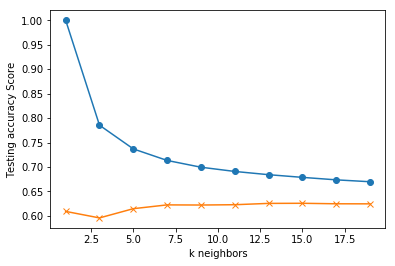

In [20]:
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

train_scores = []
test_scores = []

for k in range(1,20,2):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)

plt.plot(range(1, 20, 2), train_scores, marker='o')
plt.plot(range(1, 20, 2), test_scores, marker="x")
plt.xlabel("k neighbors")
plt.ylabel("Testing accuracy Score")
plt.show()

In [21]:
results_df = results_df.append({"model":"k_nearest_neigbors_9",
                                "train_score":train_scores[3],
                                "test_score":test_scores[3]}, 
                               ignore_index=True)
results_df

,model,test_score,train_score
0,random_forest,0.739301,0.999986
1,logistic_regression,0.608908,0.609431
2,k_nearest_neigbors_9,0.622451,0.713328


# SVM

In [22]:
# from sklearn.svm import SVC

# model = SVC(kernel='linear')
# model.fit(X_train, y_train)

# svm_train_score = model.score(X_train, y_train)
# svm_test_score = model.score(X_test, y_test)

In [23]:
# results_df = results_df.append({"model":"svm",
#                                 "train_score":svm_train_score,
#                                 "test_score":svm_test_score}, 
#                                ignore_index=True)
# results_df

# Neural Networks

In [24]:
X_train, X_test, y_cat_train, y_cat_test = train_test_split(X, y_categorical, random_state=42)

In [25]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(units=51, activation='relu', input_dim=17))
model.add(Dense(units=153, activation='relu'))
model.add(Dense(units=300, activation='relu'))
model.add(Dense(units=3,activation="softmax"))

model.compile(optimizer='adam',
             loss='mean_squared_error',
             metrics=['accuracy'])

model.fit(
    X_train,
    y_cat_train,
    epochs=10,
    shuffle=True,
    verbose=2
)

Epoch 1/10
 - 7s - loss: 0.4061 - acc: 0.3909
Epoch 2/10
 - 7s - loss: 0.4060 - acc: 0.3910
Epoch 3/10
 - 7s - loss: 0.4060 - acc: 0.3910
Epoch 4/10
 - 7s - loss: 0.4060 - acc: 0.3910
Epoch 5/10
 - 7s - loss: 0.4060 - acc: 0.3910
Epoch 6/10
 - 7s - loss: 0.4060 - acc: 0.3910
Epoch 7/10
 - 7s - loss: 0.4060 - acc: 0.3910
Epoch 8/10
 - 7s - loss: 0.4060 - acc: 0.3910
Epoch 9/10
 - 7s - loss: 0.4060 - acc: 0.3910
Epoch 10/10
 - 7s - loss: 0.4060 - acc: 0.3910


In [26]:
model_loss, model_accuracy = model.evaluate(X_test, y_cat_test, verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

Loss: 0.40496084938346355, Accuracy: 0.3925587328610441


# Dictionary of Encoded Categorical Features to Feature Names

In [27]:
country_dic = {}
currency_dic = {}
cat_dic = {}
parent_cat_dic = {}
month_dic = {}

country_list = []
country_enc_list = []
currency_list = []
currency_enc_list = []
cat_list = []
cat_enc_list = []
parent_cat_list = []
parent_cat_enc_list = []
month_list = []
month_enc_list = []

for i in range (1,len(country_encoded)):
    if kickstarter_df['country'][i] not in country_list:
        country_list.append(kickstarter_df['country'][i])
        country_enc_list.append(country_encoded[i])
    if kickstarter_df['currency'][i] not in currency_list:
        currency_list.append(kickstarter_df['currency'][i])
        currency_enc_list.append(currency_encoded[i])
    if kickstarter_df['category_name'][i] not in cat_list:
        cat_list.append(kickstarter_df['category_name'][i])
        cat_enc_list.append(category_encoded[i])
    if kickstarter_df['parent_category'][i] not in parent_cat_list:
        parent_cat_list.append(kickstarter_df['parent_category'][i])
        parent_cat_enc_list.append(parent_category_encoded[i])
    if kickstarter_df['month_started'][i] not in month_list:
        month_list.append(kickstarter_df['month_started'][i])
        month_enc_list.append(month_encoded[i])

In [28]:
print(country_list)
print(country_enc_list)
print(currency_list)
print(currency_enc_list)
print(cat_list)
print(cat_enc_list)
print(parent_cat_list)
print(parent_cat_enc_list)
print(month_list)
print(month_enc_list)

['US', 'DE', 'GB', 'NL', 'FR', 'IT', 'MX', 'SE', 'DK', 'AU', 'CA', 'IE', 'NZ', 'AT', 'BE', 'ES', 'SG', 'HK', 'CH', 'NO', 'JP', 'LU']
[21, 21, 16, 21, 21, 21, 21, 21, 1, 21, 21, 11, 21, 21, 21, 21, 2, 21, 21, 21, 15, 20]
['USD', 'EUR', 'GBP', 'MXN', 'SEK', 'DKK', 'AUD', 'CAD', 'NZD', 'SGD', 'HKD', 'CHF', 'NOK', 'JPY']
[13, 13, 4, 13, 13, 0, 13, 13, 13, 4, 13, 13, 13, 8]
['Mixed Media', 'Art', 'Painting', 'Public Art', 'Sculpture', 'Digital Art', 'Illustration', 'Conceptual Art', 'Performance Art', 'Ceramics', 'Installations', 'Video Art', 'Textiles', 'Comics', 'Comic Books', 'Webcomics', 'Graphic Novels', 'Anthologies', 'Events', 'Crafts', 'Woodworking', 'Crochet', 'DIY', 'Knitting', 'Weaving', 'Pottery', 'Stationery', 'Embroidery', 'Printing', 'Glass', 'Quilts', 'Candles', 'Taxidermy', 'Performances', 'Residencies', 'Product Design', 'Design', 'Graphic Design', 'Typography', 'Dance', 'Spaces', 'Workshops', 'Civic Design', 'Architecture', 'Accessories', 'Interactive Design', 'Apparel', 

In [29]:
for i in range(0, len(country_list)):
    country_dic[country_list[i]] = country_enc_list[i]
for i in range(0, len(currency_list)):
    currency_dic[currency_list[i]] = currency_enc_list[i]
for i in range(0, len(cat_list)):
    cat_dic[cat_list[i]] = cat_enc_list[i]
for i in range(0, len(parent_cat_list)):
    parent_cat_dic[parent_cat_list[i]] = parent_cat_enc_list[i]
for i in range(0, len(month_list)):
    month_dic[month_list[i]] = month_enc_list[i]

In [31]:
print(country_dic)
print(currency_dic)
print(cat_dic)
print(parent_cat_dic)
print(month_dic)

{'US': 21, 'DE': 21, 'GB': 16, 'NL': 21, 'FR': 21, 'IT': 21, 'MX': 21, 'SE': 21, 'DK': 1, 'AU': 21, 'CA': 21, 'IE': 11, 'NZ': 21, 'AT': 21, 'BE': 21, 'ES': 21, 'SG': 2, 'HK': 21, 'CH': 21, 'NO': 21, 'JP': 15, 'LU': 20}
{'USD': 13, 'EUR': 13, 'GBP': 4, 'MXN': 13, 'SEK': 13, 'DKK': 0, 'AUD': 13, 'CAD': 13, 'NZD': 13, 'SGD': 4, 'HKD': 13, 'CHF': 13, 'NOK': 13, 'JPY': 8}
{'Mixed Media': 10, 'Art': 95, 'Painting': 113, 'Public Art': 95, 'Sculpture': 10, 'Digital Art': 95, 'Illustration': 113, 'Conceptual Art': 28, 'Performance Art': 10, 'Ceramics': 97, 'Installations': 28, 'Video Art': 10, 'Textiles': 127, 'Comics': 26, 'Comic Books': 26, 'Webcomics': 26, 'Graphic Novels': 26, 'Anthologies': 26, 'Events': 26, 'Crafts': 153, 'Woodworking': 32, 'Crochet': 153, 'DIY': 32, 'Knitting': 32, 'Weaving': 32, 'Pottery': 134, 'Stationery': 33, 'Embroidery': 32, 'Printing': 34, 'Glass': 33, 'Quilts': 32, 'Candles': 33, 'Taxidermy': 117, 'Performances': 98, 'Residencies': 121, 'Product Design': 112, 'De